In [266]:
import numpy as np
from typing import Tuple


def sig1(n1: float, n2: float) -> np.ndarray:
    return np.sin(2 * np.pi * n1 + 3 * np.pi * n2)


def sig2(n1: float, n2: float) -> np.ndarray:
    return np.sin(4 * np.pi * n1) + np.cos(6 * np.pi * n2)


def pixels(width: int, height: int) -> Tuple[np.ndarray, np.ndarray]:
    h_points = np.arange(width)
    v_points = np.arange(height)

    h_coord = np.tile(h_points, (height, 1))
    v_coord = np.tile(np.expand_dims(v_points, axis=0).T, (1, width))

    return h_coord, v_coord


def time1(width: int, height: int) -> np.ndarray:
    h, v = pixels(width, height)
    return sig1(h, v)


def time2(width: int, height: int) -> np.ndarray:
    h, v = pixels(width, height)
    return sig2(h, v)


def freq1(width: int, height: int) -> np.ndarray:
    if min(width, height) <= 5:
        raise ValueError('width, height must be equal or greater than 5')
    Y = np.zeros((width, height))
    Y[0][5] = Y[0][width - 5] = 1.0
    return Y


def freq2(width: int, height: int) -> np.ndarray:
    if min(width, height) <= 5:
        raise ValueError('width, height must be equal or greater than 5')
    Y = np.zeros((width, height))
    Y[5][0] = Y[height - 5][0] = 1.0
    return Y


def freq3(width: int, height: int) -> np.ndarray:
    if min(width, height) <= 5:
        raise ValueError('width, height must be equal or greater than 5')
    Y = np.zeros((width, height))
    Y[5][5] = Y[width - 5][height - 5] = 1.0
    # Y[height - 1][width - 1] = 1.0
    return Y


In [267]:
def freq_to_time(freq: np.ndarray) -> np.ndarray:
    return np.real(np.fft.ifft2(freq))


def time_to_freq(time: np.ndarray) -> np.ndarray:
    return np.fft.fft2(time)


In [268]:
N = 10
width, height = N, N

t1 = time1(width, height)
t2 = time2(width, height)
t3 = None
t4 = None
t5 = None

f1 = None
f2 = None
f3 = freq1(width, height)
f4 = freq2(width, height)
f5 = freq3(width, height)

f1 = time_to_freq(t1)
f2 = time_to_freq(t2)
t3 = freq_to_time(f3)
t4 = freq_to_time(f4)
t5 = freq_to_time(f5)

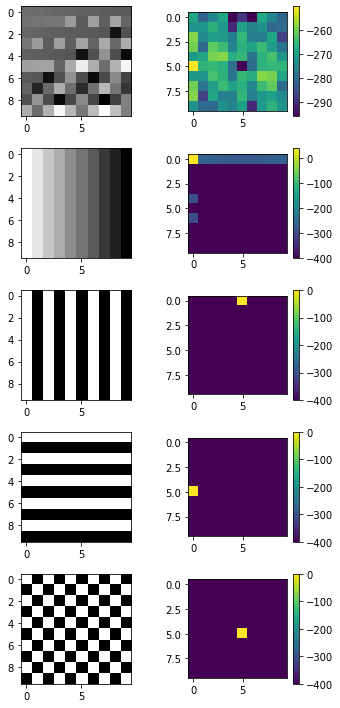

In [269]:
import matplotlib.pyplot as plt

inputs = [
    (t1, f1),
    (t2, f2),
    (t3, f3),
    (t4, f4),
    (t5, f5),
]

fig, axis = plt.subplots(len(inputs), len(inputs[0]), figsize=(5, 10))
fig.tight_layout()

for i, (time, freq) in enumerate(inputs):
    im_time = axis[i][0].imshow(time, cmap='gray')
    im_freq = axis[i][1].imshow(20 * np.log10(np.abs(freq) + 1e-20))
    fig.colorbar(im_freq, ax=axis[i][1])


**Observation**: For the second row shown above, you can notice that
the image shows a grayscale gradient caused by some floating point errors
caused by the sin function.

SNR Threshold = 2.39
Optimum SNR = 2.382995381660462
Initial SNR=2.0737716391704213


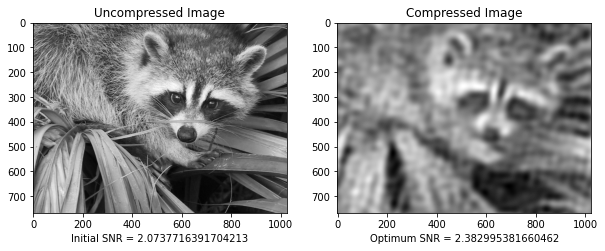

In [283]:
from scipy import misc, ndimage

def snr(signal: np.ndarray):
  mean = np.mean(signal)
  std  = np.std(signal)
  return mean / std

# Load the image in memory
X = misc.face(gray=True)
X_compressed = X

# Set a custom SNR threshold for compression
snr_threshold = 2.39

# Convert to frequency domain
Y = np.fft.fft2(X)
Y_spectrum = np.abs(Y)
Y_coefficients = np.flip(np.sort(Y_spectrum.flatten()))

# Initialize the optimum value
X_optim = X_compressed
interval = np.array((0.0, 1.0))
threshold_previous = -1
threshold_counter = 0

# Find optimum values
while np.abs(snr(X_compressed) - snr_threshold) >= 1e-2:
  threshold = np.mean(interval)

  threshold_index = int(np.min(
      (
        threshold * Y_coefficients.shape[0],
        Y_coefficients.shape[0] - 1
      )
    )
  )

  if threshold_previous == -1:
    threshold_previous = threshold_index

  threshold_value = Y_coefficients[threshold_index]

  compression_mask = Y_spectrum >= threshold_value

  Y_compressed = compression_mask * Y

  X_compressed = np.real(np.fft.ifft2(Y_compressed))

  snr_current = snr(X_compressed)

  if snr_current > snr_threshold:
    interval[0] = threshold
  elif snr_current < snr_threshold:
    interval[1] = threshold
    X_optim = X_compressed

  if threshold_previous == threshold_index:
    threshold_counter += 1
  else:
    threshold_counter = 0

  if threshold_counter >= 10:
    break

  threshold_previous = threshold_index

fig, (uncompressed_axis, compressed_axis) = plt.subplots(1, 2, figsize=(10, 5))

compressed_axis.set_title('Compressed Image')
compressed_axis.set_xlabel(f'Optimum SNR = {snr(X_optim)}')
compressed_axis.imshow(X_optim, cmap=plt.cm.gray)

uncompressed_axis.set_title('Uncompressed Image')
uncompressed_axis.set_xlabel(f'Initial SNR = {snr(X)}')
uncompressed_axis.imshow(X, cmap=plt.cm.gray)

print(f'SNR Threshold = {snr_threshold}')

print(f'Optimum SNR = {snr(X_optim)}')

print(f'Initial SNR={snr(X)}')

plt.show()

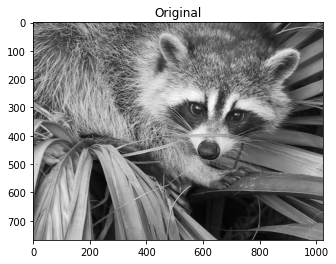

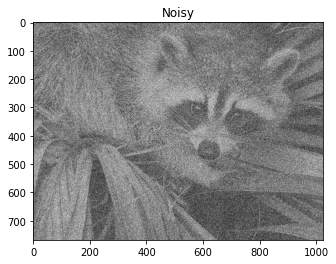

In [278]:
pixel_noise = 200

noise = np.random.randint(-pixel_noise, high=pixel_noise+1, size=X.shape)
X_noisy = X + noise
plt.imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.show()
plt.imshow(X_noisy, cmap=plt.cm.gray)
plt.title('Noisy')
plt.show()